# Introduction 

MSc in Data Analytics & Artifical Intelligence - Advanced Data Science 

Project 2 : OLIST's customer segmentation

- Charles LIETAR : 57488
- Hojun JUNG : 61781
- Omar EL HAJJAR : 74098

## Problem framing

### Context

Olist, a sales solution for online markeplaces wants to develop a customer segmentation that its marketing teams can use on a routine basis for their communication campaigns.


### Goals



1.  Olist marketing teams need an actionable description of the segmentation that allows them to thoroughly grasp its underlying logic .
2.   The quality of the data is somewhat poor. The idea is to create the best possible features for making optimum use of them, like Recency, Frequency and Monatary variables
2.  The segmentation needs to be robust: adding a few new customers to the database and creating a new segmentation using the same model should not result in totally different conclusions





### Machine Learning Approach

Customer segmentation means understanding the different types of users. Unsupervised algorithms like clustering are probably the best to use.

We will apply K-means clustering model  (a distance-based technique) and Gaussian Mixture models (probabilistic-based technique)  and compare them.

Our objective will thus to find the optimal number of clusters, and evaluate how consistent, robust and stable is our clustering strategy.

## Data description

### Business description

Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.



*   An order might have multiple items.
*   Each item might be fulfilled by a distinct seller.


## Data Schema 

The data is divided in multiple datasets for better understanding and organization. 

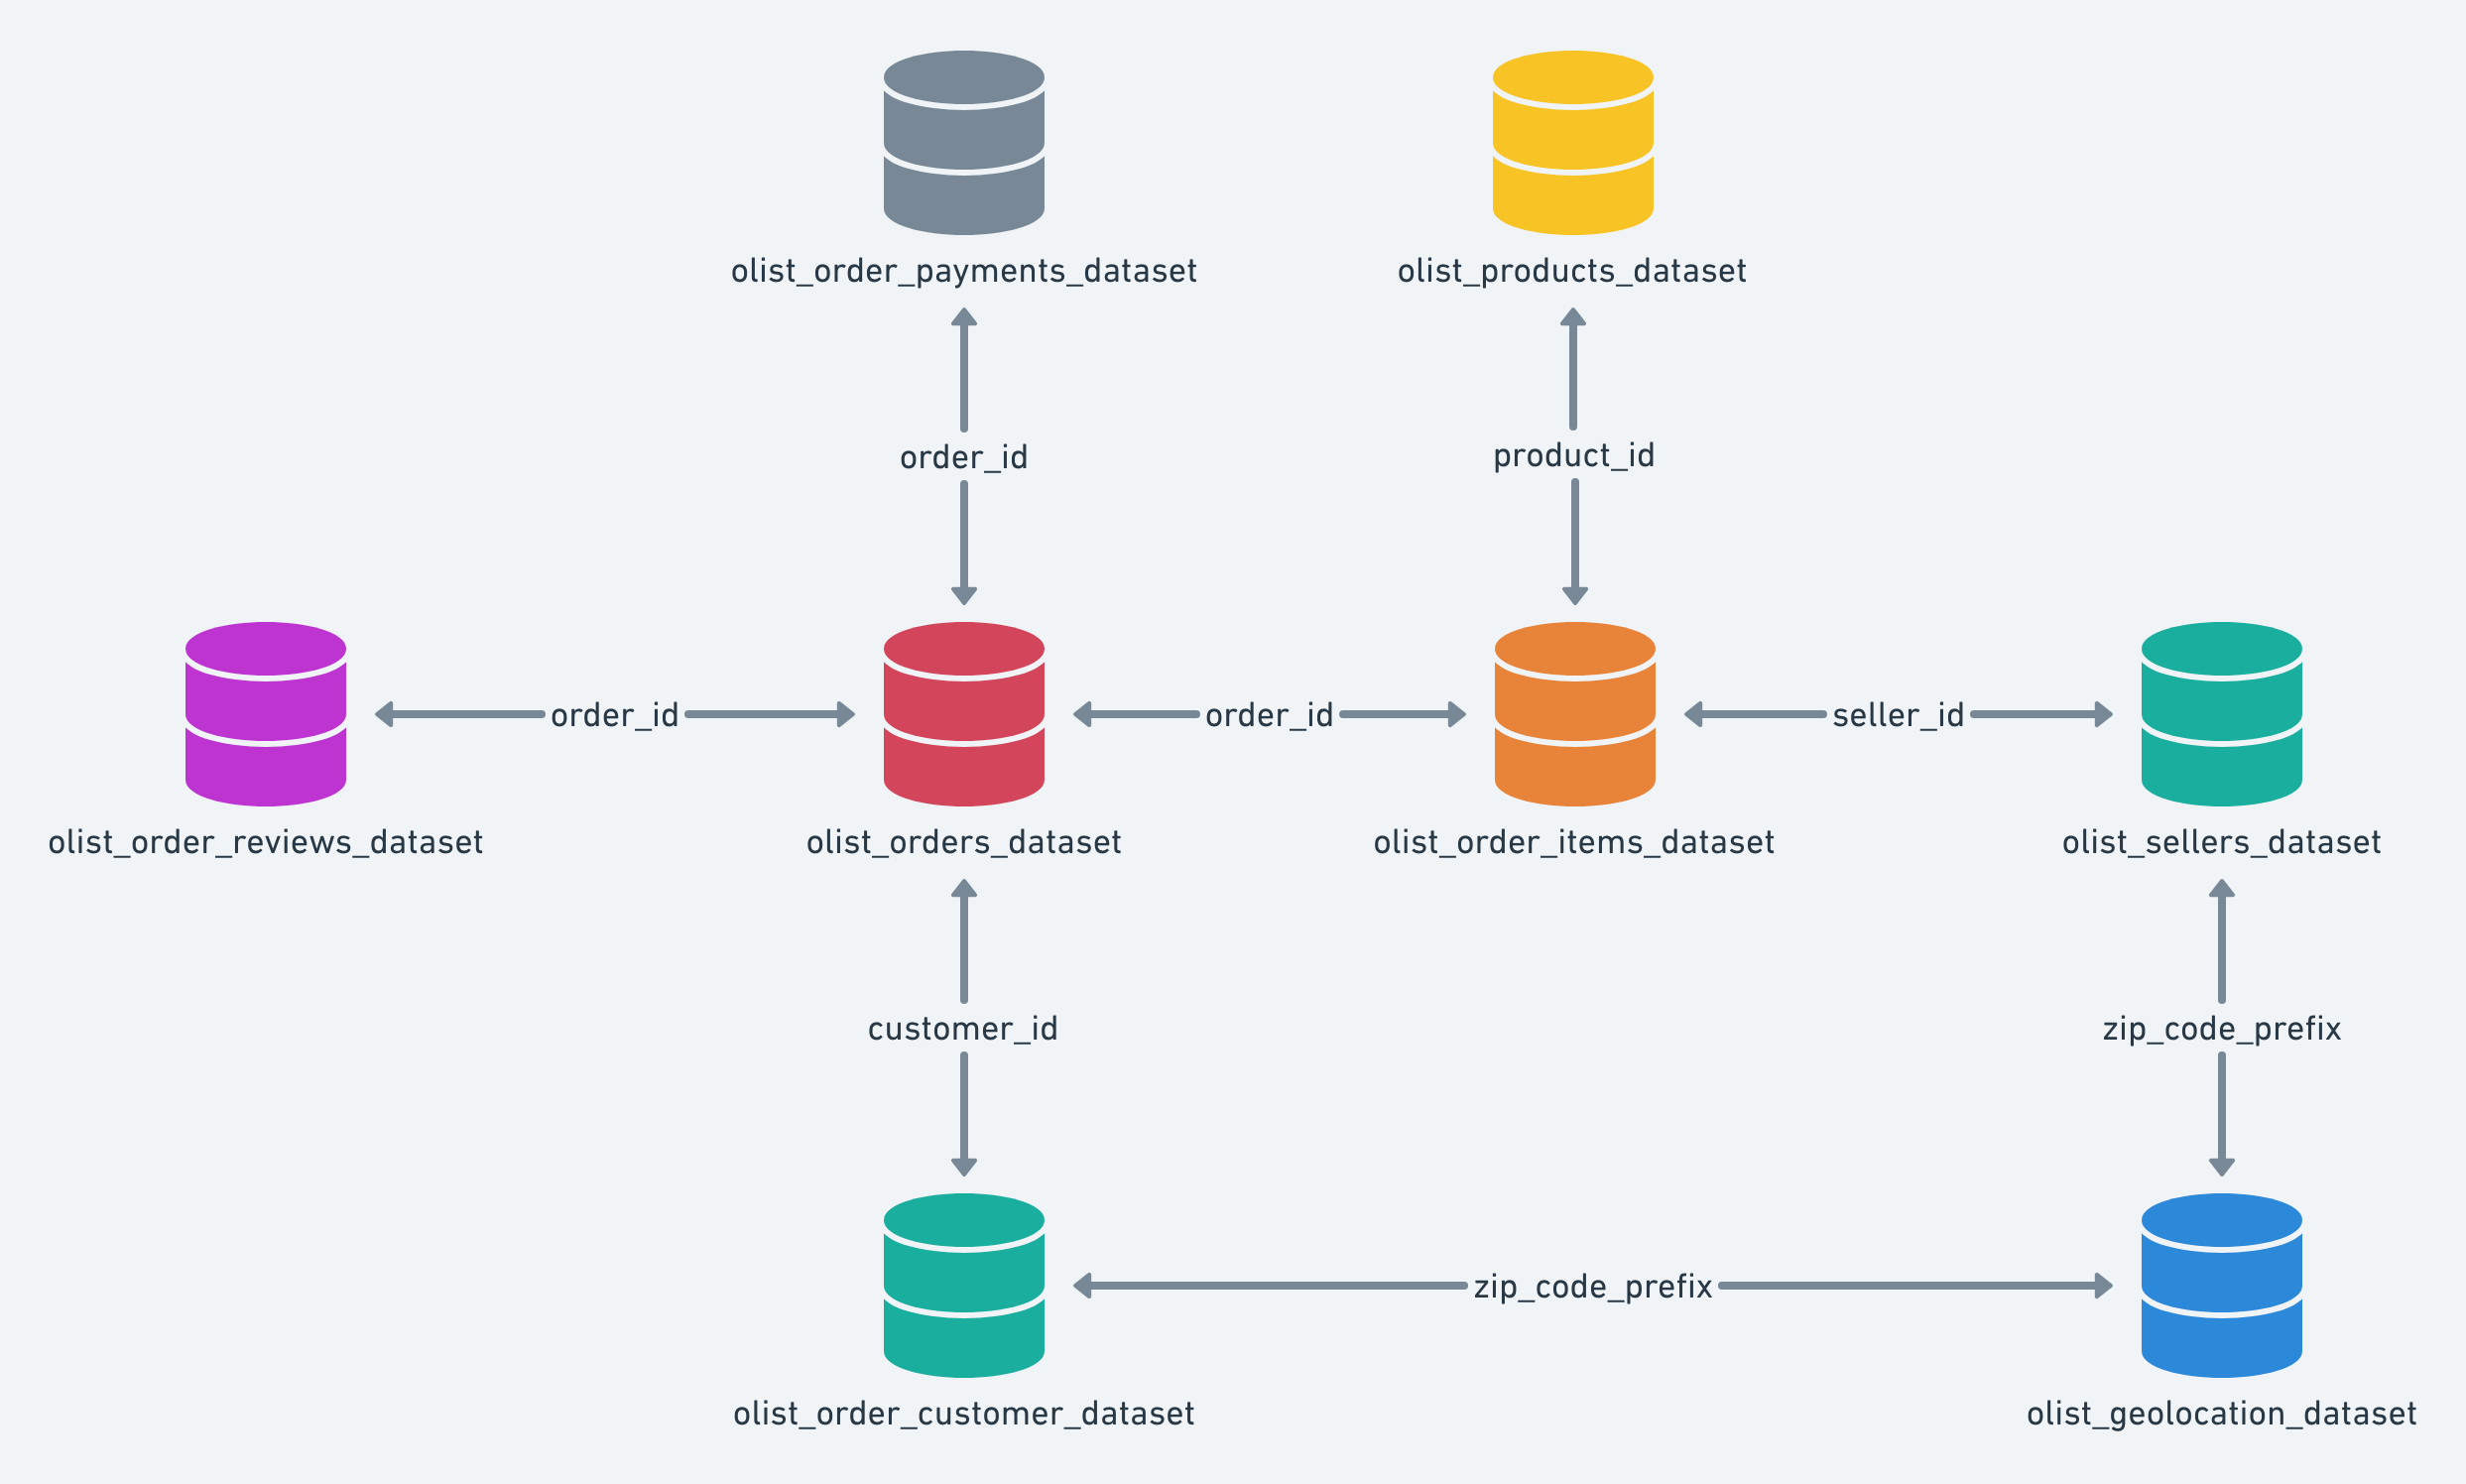

# Loading datasets & importing required packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
orders = pd.read_csv('/content/gdrive/MyDrive/Data_segmentation/olist_orders_dataset.csv')
orders_reviews = pd.read_csv('/content/gdrive/MyDrive/Data_segmentation/olist_order_reviews_dataset.csv')
payments = pd.read_csv('/content/gdrive/MyDrive/Data_segmentation/olist_order_payments_dataset.csv')
products = pd.read_csv('/content/gdrive/MyDrive/Data_segmentation/olist_products_dataset.csv')
order_items = pd.read_csv('/content/gdrive/MyDrive/Data_segmentation/olist_order_items_dataset.csv')
customers = pd.read_csv('/content/gdrive/MyDrive/Data_segmentation/olist_customers_dataset.csv')
sellers = pd.read_csv('/content/gdrive/MyDrive/Data_segmentation/olist_sellers_dataset.csv')
geolocation = pd.read_csv('/content/gdrive/MyDrive/Data_segmentation/olist_geolocation_dataset.csv')


In which :


*   `orders ` : core dataset of orders placed by customers

*   `orders_reviews` : data about the reviews made by the customers.

*   `payments` : data about the orders payment options
*   `products` : data about the products sold by Olist.


*   `order_items` : data about the items purchased within each order.


*   `order_customer` :  information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

*   `sellers ` : data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.
*   `geolocation ` :  information of Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.





# Q1. Designing our  customer basetable 

We first need to store and gather relevant information per customer in a single dataframe object, which will be our basetable for computing the RFM variables


*   R stands for Recency : How recently did the customer purchase?
*   F stands for Frequency : How often do they purchase?
*   M stands for Monetary : How much do they spend?


Since the dataset is not actual by 2021, thus we should assume that we were asked to perform RFM analysis the day after the last record




To do so, we will use 3 datasets : 



*   orders : our base table from wich we will retrieve information and compute the RFM variables
*   payments : we will fetch the total amount by order_id  from it  (since customers can pay with installements for an order)
*   customers : we will fetch the customer key identification "customer_unique_id" from it 

We finally need to decide the timestamp variable that recorded the latest purchase of a customer : we choose `order_approved_at` from the orders table. 
In fact, we can't opt for `order_purchase_timestamp` because some customers can see their purchase refused. 






### 1.Preparing datasets

#### i. Checking datatypes on orders table

In [ ]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

`order_approved_at` is not from a datetime datatype , let's convert it 

In [ ]:
orders["order_approved_at"] =  pd.to_datetime(orders['order_approved_at'])

#### ii. Checking for missing values

In [ ]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

160 orders were not approved.  We should drop them. 

In [ ]:
to_drop = orders[orders['order_approved_at'].isna()].index
orders = orders.drop(to_drop)

In [ ]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date     1637
order_delivered_customer_date    2819
order_estimated_delivery_date       0
dtype: int64

#### ii. Defining the end date from which we will compute the recency of a customer

In [ ]:
last_date = orders ['order_approved_at'].max() + pd.to_timedelta(1, 'D') #add one day
last_date

Timestamp('2018-09-04 17:40:06')

We will thus pretend today is the 4th of September 2018, and we want to know how recently our customers  last purchased something. 

### 2. Retrieving key information for the RFM computations 

#### i. Retrieving customer_unique_id in our orders table

In [ ]:
orders = pd.merge(orders, customers, how="inner", on= "customer_id")

#### ii. Retrieving the total amount of value spent per order (since customers can pay with several installements)

In [ ]:
orders  = pd.merge(orders, payments.groupby('order_id').agg(Total= ('payment_value', 'sum')), on="order_id")

#Q2. Understand, analyse and clean the dataset

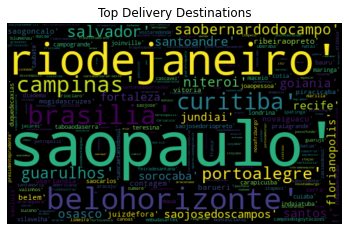

In [ ]:
# which city is the top destination of delivery?

from wordcloud import WordCloud
import re

#allWords = ''.join([city for city in orders['customer_city']])
allWords =  orders['customer_city'].tolist()
allWords = re.sub(" ", "", str(allWords))
allWords = ''.join(str(e) for e in allWords)

wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.title("Top Delivery Destinations")
plt.show()

Two most frequent delivery destinations are 'Rio de Janeiro' and 'Sao Paulo'.

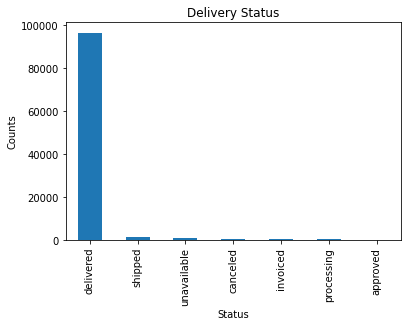

In [ ]:
plt.title("Delivery Status")
plt.xlabel("Status")
plt.ylabel("Counts")
orders['order_status'].value_counts().plot(kind = 'bar')
plt.show()

Most of parcels were delivered. Only few are canceled which could cause churn for the operation of Olist.

In [ ]:
print("Only ", round(orders['order_status'].value_counts()["canceled"]*100/len(orders), 2), "% of the total orders was canceled.")

Only  0.49 % of the total orders was canceled.


In [ ]:
orders["order_id"].value_counts().value_counts() 

1    99280
Name: order_id, dtype: int64

From this we can conclude that not a single order includes more than 1 item. Hence, no need to create a "Average number of items per order" for each customer, since it will only be equal to 1 for all customers

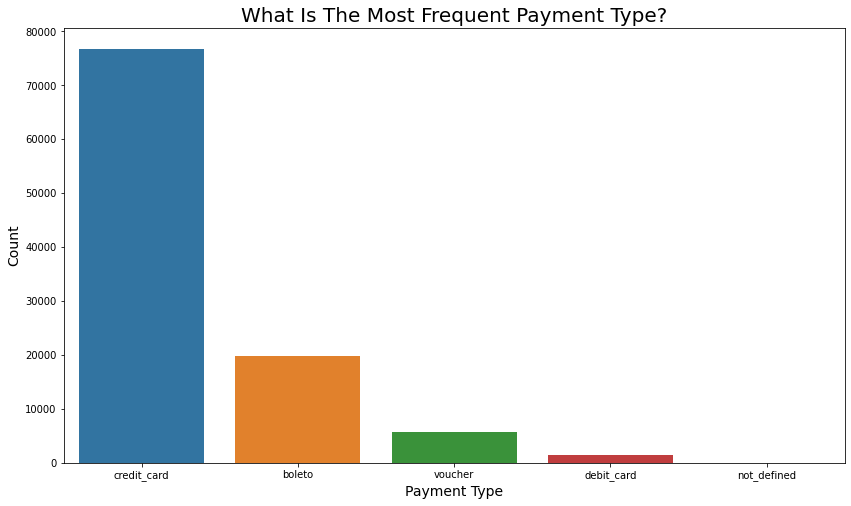

In [ ]:

plt.figure(figsize=(14,8))

sns.countplot(x = 'payment_type', data = payments)

plt.title('What is the most frequent payment type?'.title() , fontsize=20);
plt.ylabel('count'.title(), fontsize=14);
plt.xlabel('payment type'.title(), fontsize=14);
plt.show()

The number of purchases are heavily imbalanced with credit_card consissting of most of the transactions. Let's dive deeper to see how much % it takes part of.

In [ ]:
print(round(payments['payment_type'].value_counts()['credit_card']/len(payments['payment_type'])*100, 2),
      "% of customers are paying by credit card. This feature might distort the result of k-means. Hence, we will drop this feature.")

73.92 % of customers are paying by credit card. This feature might distort the result of k-means. Hence, we will drop this feature.


In [ ]:
print(orders.shape)
print(order_items.shape)

(99280, 13)
(112650, 7)


In [ ]:
print(set(orders["order_id"]).issubset(set(order_items["order_id"])))  

False


In [ ]:
len(set(orders["order_id"]) - set(order_items["order_id"]))

629

For some reason, the datasets given to us have some error, where some order_id in orders dataset does not exist in the order_item dataset. 

For that, when merging orders and order_item we will have 629 NAN, which will need to be fixed

In [ ]:
items_and_order = pd.merge(orders, order_items, how="left", on= "order_id")
items_and_order["product_id"].isna().sum()

629

As we see in the output of the above cell, we have the 629 Nulls.We can replace those null values by any value, since the value wont affect the computation of the `average_item_per_order`. 

Note 1: We're getting rid of the null values as we want to count them when computing the `average_item_per_order`. 

Note 2: Our imputation technique assumes that the orders having `product_id` = null correspond to orders with 1 item.

In [ ]:
items_and_order["product_id"]=items_and_order["product_id"].fillna(value=items_and_order["product_id"][0])

In [ ]:
items_and_order["product_id"].isna().sum()

0

In [ ]:
customer_total_items = items_and_order.groupby("customer_unique_id")["product_id"].count()
customer_total_items

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: product_id, Length: 95996, dtype: int64

In [ ]:
customer_total_orders = orders.groupby("customer_unique_id").size()
customer_total_orders

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    1
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Length: 95996, dtype: int64

In [ ]:
avg_items_per_order = (customer_total_items/customer_total_orders)
avg_items_per_order.value_counts(normalize=True).head(4)

1.0    0.899506
2.0    0.073545
3.0    0.012417
4.0    0.004729
dtype: float64

89% of the orders only have 1 item 




#Q3 Get our RFM table

## Q3.1 Creating the RFM variables 

In [ ]:
RFM = orders.groupby('customer_unique_id').agg(Recency= ('order_approved_at', lambda x: (last_date - x.max()).days ),
                                              Frequency= ('order_id', 'size'),
                                              Monetary= ('Total', 'sum'))
RFM.describe()

,Recency,Frequency,Monetary
count,95996.000000,95996.000000,95996.000000
mean,244.245958,1.034210,166.379249
std,153.275420,0.212522,229.309020
min,1.000000,1.000000,9.590000
25%,120.000000,1.000000,63.110000
50%,225.000000,1.000000,107.960000
75%,354.000000,1.000000,183.400000
max,700.000000,17.000000,13664.080000


In [ ]:
RFM.Recency.max()

700

## Q3.2 Performing some EDA on the RFM table & adapting our cleaning process

### Looking at the Recency variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


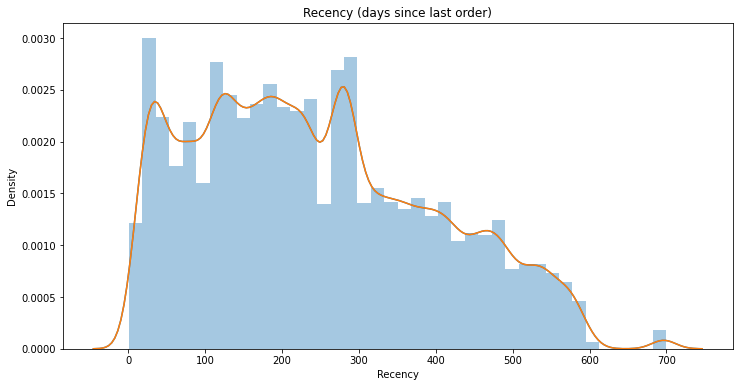

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Recency (days since last order)')
sns.distplot(RFM["Recency"], kde=True, bins = 40)
sns.kdeplot(RFM["Recency"]);

It's not a good idea to keep people who have very high recency as the data corresponding to those individuals might be outdated and not useful for today's business need. 

We can pick a date in which we think the data after it might be useful. For example, last 7 months: 7*30 = 210 days

In [ ]:
RFM = RFM.loc[RFM["Recency"]<=210]

### Looking at the Monetary variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    44843.000000
mean       168.223965
std        228.110763
min          9.590000
25%         63.280000
50%        110.460000
75%        185.915000
90%        322.156000
95%        487.662000
98%        813.347600
max       7274.880000
Name: Monetary, dtype: float64

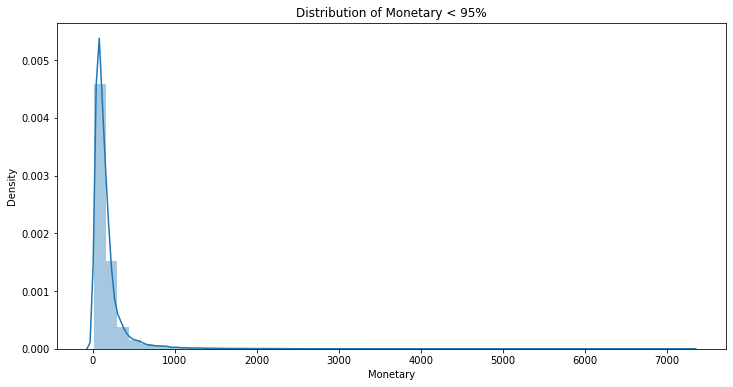

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Distribution of Monetary < 95%')
sns.distplot(RFM['Monetary']);

RFM['Monetary'].describe([0.25, 0.5, 0.75, 0.9, 0.95,0.98])

We can see that the monetary data is highly right skewed. We can choose 475 to filter out the outliers. Indeed, we will be applying K-Means clustering as a segmentation algorithm later one, and this technique is highly sensitive to outliers. 

In [ ]:
RFM = RFM.loc[RFM['Monetary']<475]

### Looking at the Frequency variable 

In [ ]:
RFM["Frequency"].value_counts(normalize=True)*100 

1    97.007833
2     2.796923
3     0.171720
4     0.018819
5     0.004705
Name: Frequency, dtype: float64

We can see that 97% of the users are 1-time users. We should then drop it for the segmentation method we are going to apply.

In [ ]:
RFM =RFM.drop("Frequency", axis=1)

# Q4 Designing the segmentation dataset

## Q4.1 Justifying features of interest

To perform our segmentation among our customers, we will use an unsupervised method called K-Means clustering.  To fit this method, we first need to select the variables that will best explain our customer clusters. 

We first choose to select :


*   Recency variable : when was the last order of the customer ? 
*   Monatary variable : How much did the customer spend in total? 

We then propose to compute an other variable which is :

*   average_review_score : In average, how satisfy was the customer ?



We can thus cluster our customer regarding 3 strong customer relationship indicator : the value customers bring to the business (Monetary), their fidelity (Recency), their satisfaction regarding business operations (avg_review_score).







##Q4.2 Creating the segmentation dataset

### Creating the average customer review score

In [ ]:
#getting the average customer reviews back in our order dataframe

customers_reviews = pd.merge(orders_reviews, orders, how="inner", on= "order_id")
customers_reviews = customers_reviews.groupby("customer_unique_id").agg(avg_review_score= ('review_score', 'mean'))

### Setting up the segmentation dataset 

In [ ]:
#adding avg_review_score to our segmentation dataframe, as well as the RFM variables 
segmentation = pd.merge(RFM, customers_reviews, how="inner", on= "customer_unique_id")

In [ ]:
segmentation.head()

,Recency,Monetary,avg_review_score
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119,27.19,4.0
0004bd2a26a76fe21f786e4fbd80607f,151,166.98,4.0
00050ab1314c0e55a6ca13cf7181fecf,132,35.38,4.0
00053a61a98854899e70ed204dd4bafe,188,419.18,1.0


#Q5 Clustering

In order to perform our customer segmentation, we will use two clustering techniques based on K-Means algorithm :



*   K-means model : the algorithm clusters data by trying to separate samples in K groups of equal variance, using the euclidian distance. 

*   Guassian Mixture models : a probabilistic algorithm  that will use K independent Gaussian distributions to model K separated clusters, using the expectation-maximization algorithm to do so. 


For both methods, we will need to find the optimal number of clusters K, which need to be specified when fitting the algorithms on our data.






## Q5.1 Normalizing our features 

In order to apply any clustering algorithms, we need to rescale our data to avoid feature domination in the distance formula we use to define our  clusters (such as the euclidian distance). Let's use the Z-score normalization technique.


In [ ]:

from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
segmentation_scaled = pd.DataFrame(standardscaler.fit_transform(segmentation), index=segmentation.index, columns=segmentation.columns)


In [ ]:
segmentation_scaled.head(5)

,Recency,Monetary,avg_review_score,cluster_pred_optimal
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.108661,0.146415,0.673561,-0.309353
0000b849f77a49e4a4ce2b2a4ca5be3f,0.142189,-1.126667,-0.072265,-0.309353
0004bd2a26a76fe21f786e4fbd80607f,0.678646,0.424759,-0.072265,-0.309353
00050ab1314c0e55a6ca13cf7181fecf,0.360125,-1.035772,-0.072265,-0.309353
00053a61a98854899e70ed204dd4bafe,1.298925,3.223740,-2.309744,-1.708086


## Q5.2 Clustering with K-means 

Let's first fit a KMean clustering algorithm. We will pick 4 clusters to start. 

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(segmentation_scaled)

 Let's evaluate this naive fit with **the average of each observation's silouhette coefficient.**
 
**The silhouette coefficient** is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The value of the silhouette ranges between [1, -1], where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.


$$ Silhouette \hspace{0.5cm} coefficient =  \frac{X-Y} {\max(X, Y)}$$



Steps to find the silhouette coefficient of an i’th point:
Compute a(i): The average distance of 

*   Compute a(i): The average distance of that point with all other points in the same clusters.
*   Compute b(i): The average distance of that point with all the points in the closest cluster to its cluster
*   Compute s(i) — silhouette coefficient or i’th point using below mentioned formula.




$$  s(i) = \frac{b(i) - a(i) } {\max(b(i), a(i))}$$

We thus take the average of all silouhette coefficients to get **the silouhette score.**




In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(segmentation_scaled, kmeans_labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.3728946062344815


## Q5.3 Clustering with Gaussian Mixture models

Let's then proceed with the same naive fit using Gaussian Mixture

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(segmentation_scaled)
labels = gmm.predict(segmentation_scaled)

Let's then evaluate this method with the silouhette score as well.

In [ ]:
gmm_avg = silhouette_score(segmentation_scaled, labels)
print("The average silhouette_score is :", gmm_avg)

The average silhouette_score is : 0.11755805525931612





Following those Naive fits, let's try to find the optimal number of clusters maximizing the silouhette score, and thus the cohesion each cluster and separation among them.

# Q6 Finding optimal number of clusters

## Q6.1 Searching for the optimal K using K means clustering

The Elbow method is mainly about plotting the silouhette score we defined above vs the Number of Clusters used.
 And we will be checking for a number of clusters that forms an elbow shape, meaning that the slope of our line changes highly when it
goes into the number of clusters

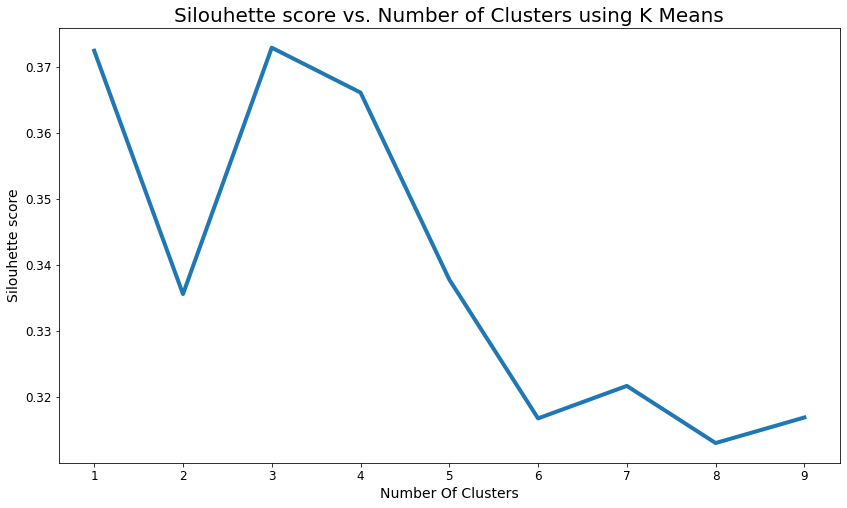

In [ ]:
sil = []
kmax = 10
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(segmentation_scaled)
  labels = kmeans.labels_
  sil.append(silhouette_score(segmentation_scaled, labels, metric = 'euclidean'))

plt.figure(figsize=(14,8))

plt.plot(range(1,10), sil, linewidth=4);
plt.xlabel('Number of clusters'.title())
plt.ylabel('Silouhette score'.title())

plt.title('Silouhette score vs. Number of Clusters using K Means', fontsize=20);
plt.ylabel('Silouhette score', fontsize=14);
plt.xlabel('Number of Clusters'.title(), fontsize=14);

plt.xticks(rotation=0, fontsize= 12);
plt.yticks(fontsize=12)
plt.show()



## Q6.2 Searching for the optimal K with Gaussian Mixture models

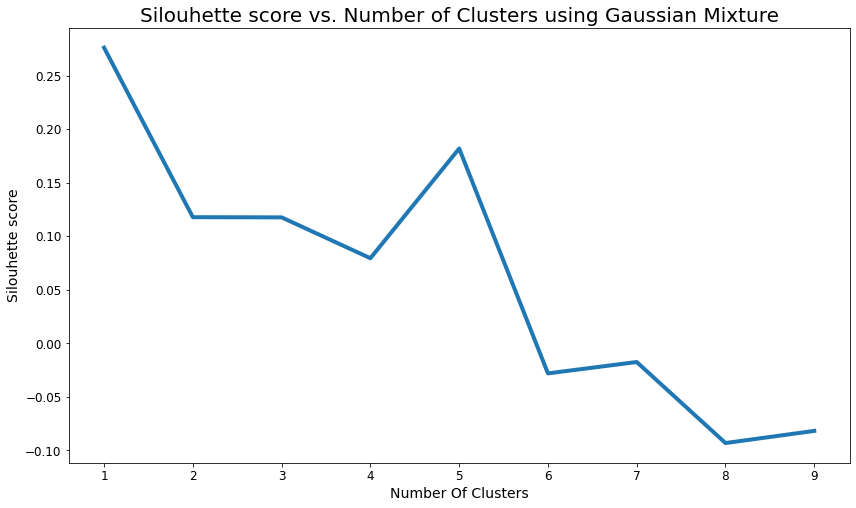

In [ ]:
sil = []
kmax = 10
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  gmm = GaussianMixture(n_components = k).fit(segmentation_scaled)
  labels = gmm.predict(segmentation_scaled)
  sil.append(silhouette_score(segmentation_scaled, labels, metric = 'euclidean'))

plt.figure(figsize=(14,8))

plt.plot(range(1,10), sil, linewidth=4);
plt.xlabel('Number of clusters'.title())
plt.ylabel('Silouhette score'.title())

plt.title('Silouhette score vs. Number of Clusters using Gaussian Mixture', fontsize=20);
plt.ylabel('Silouhette score', fontsize=14);
plt.xlabel('Number of Clusters'.title(), fontsize=14);

plt.xticks(rotation=0, fontsize= 12);
plt.yticks(fontsize=12)
plt.show()


## Q6.3 Selecting the best method for final clustering

The more we increase the number of clusters while fitting a Gaussian Mixute, the lower the silouhette score tends to be. Yet, for K= 5 the silouhette score reached 0.20. 

However, when it comes to K-means clustering algorithm, we can see the optimal number of clusters maximizing the silouhette score is reached with 3 clusters, at silouhette score = 0.37


As we prefer simple models with highest silouhette score, we will go for K-means clustering with K=3.

In [ ]:
from sklearn.cluster import KMeans
kmeans_final = KMeans(n_clusters = 3).fit(segmentation_scaled)
segmentation_scaled['cluster_pred_optimal'] = kmeans_final.predict(segmentation_scaled)

Let's retrieve our cluster predictions for the our unscaled observations, for data visualization matters.

In [ ]:
segmentation = pd.merge(segmentation, segmentation_scaled['cluster_pred_optimal'], how="left", left_index=True, right_index=True)

In [ ]:
segmentation

,Recency,Monetary,avg_review_score,cluster_pred_optimal
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,141.90,5.0,2
0000b849f77a49e4a4ce2b2a4ca5be3f,119,27.19,4.0,2
0004bd2a26a76fe21f786e4fbd80607f,151,166.98,4.0,2
00050ab1314c0e55a6ca13cf7181fecf,132,35.38,4.0,2
00053a61a98854899e70ed204dd4bafe,188,419.18,1.0,1
...,...,...,...,...
fff22793223fe80c97a8fd02ac5c6295,70,89.19,5.0,0
fff2ae16b99c6f3c785f0e052f2a9cfb,137,200.90,5.0,2
fff3e1d7bc75f11dc7670619b2e61840,46,82.51,5.0,0


#Q7 Analyse customer clusters & find different behaviors

##Q7.1 Plotting all possible scatter plots using the variables describing the segmentation

Text(0.5, 1.0, 'Monetary vs Avg_Review_score')

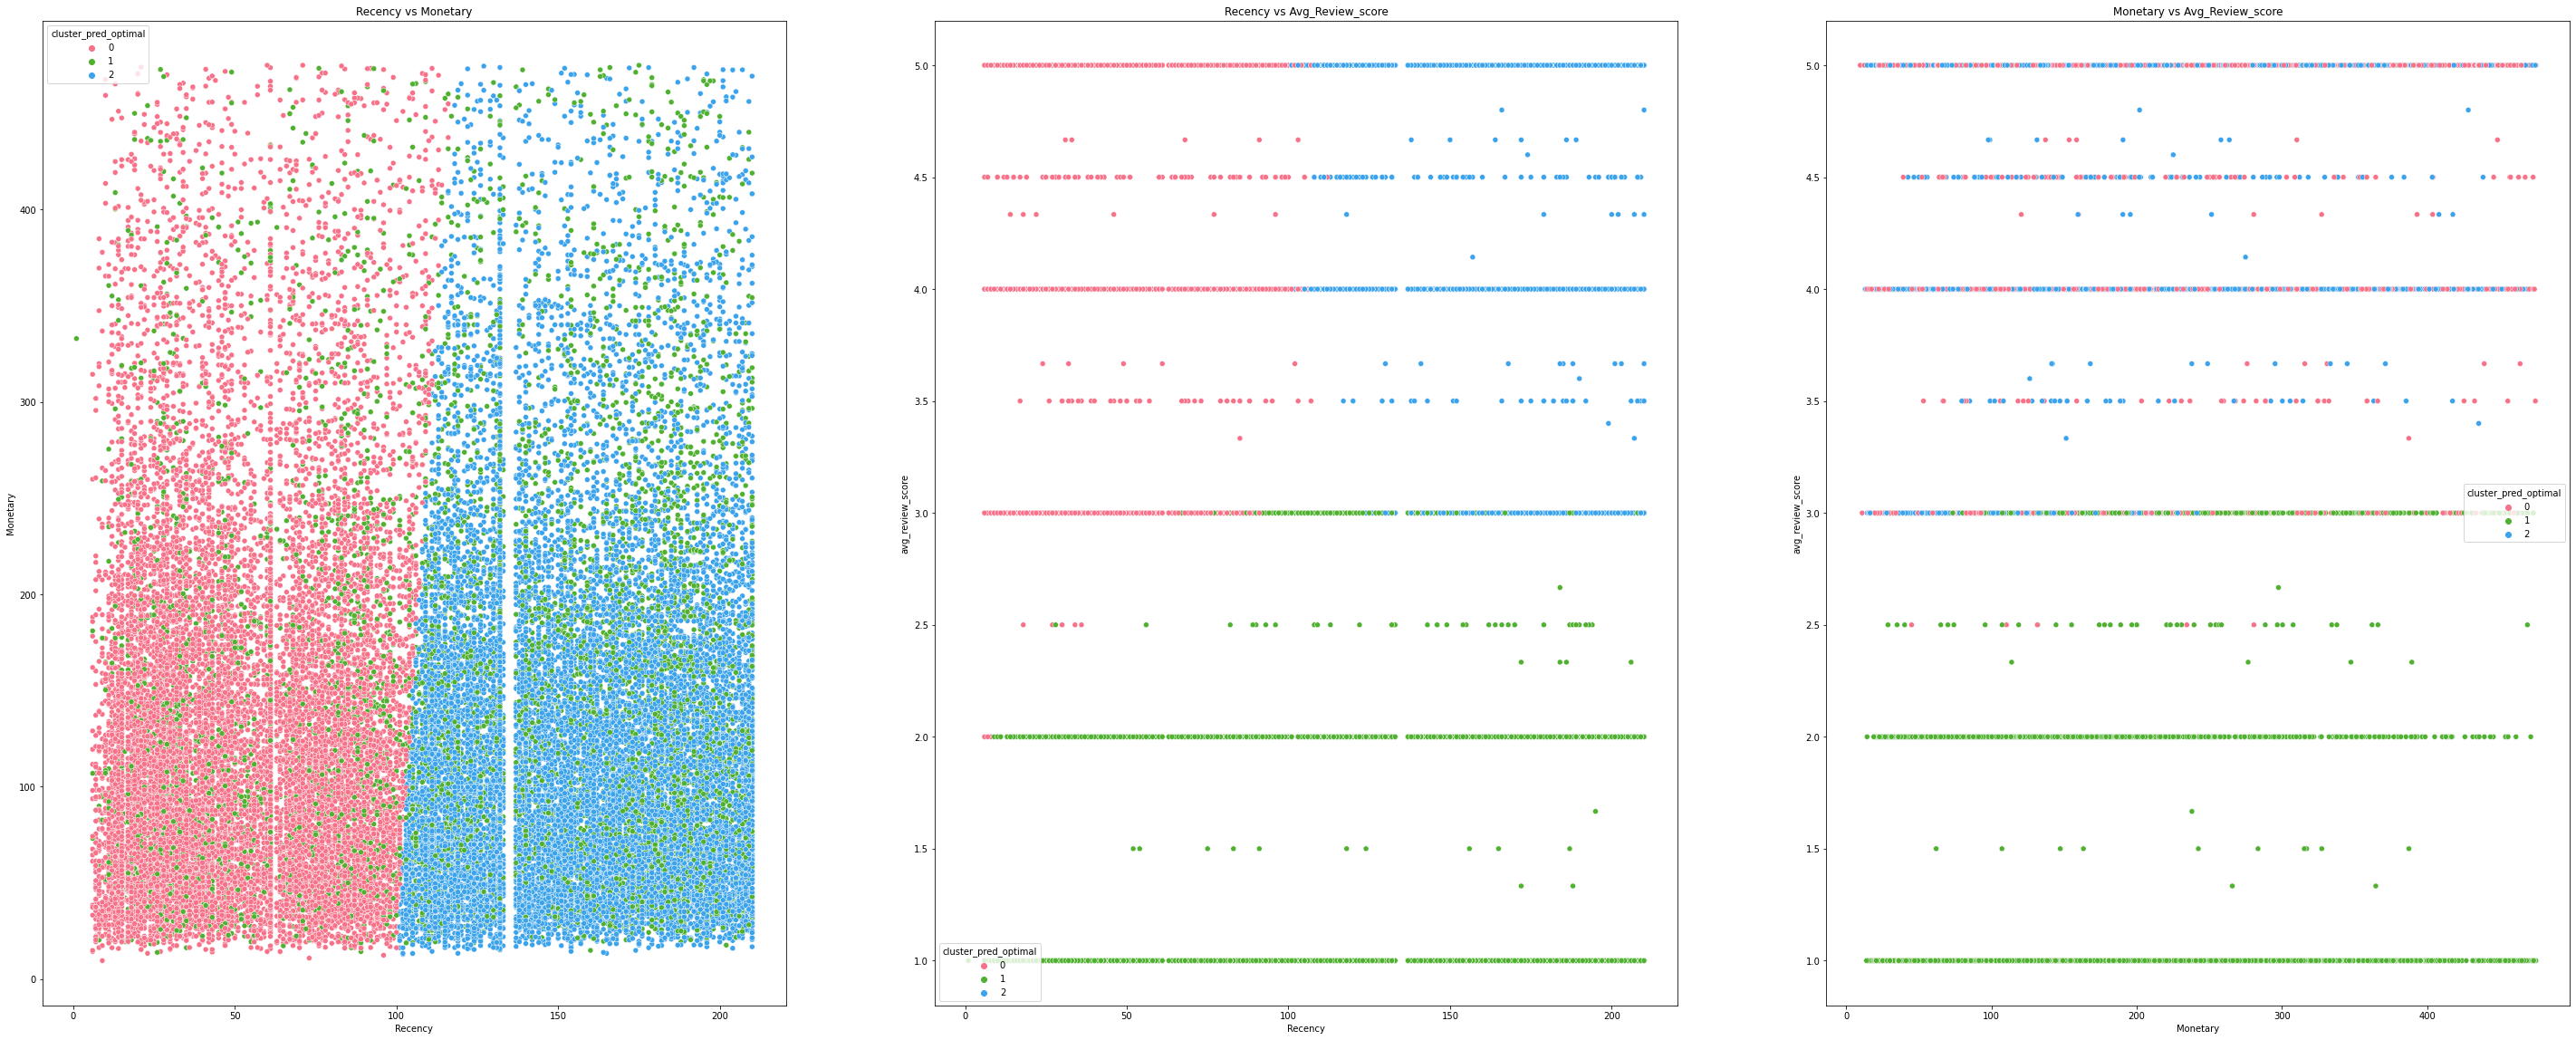

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (50, 20))

sns.scatterplot(ax=axes[0],data=segmentation,x='Recency', y='Monetary', hue="cluster_pred_optimal", palette=sns.color_palette("husl", 3))
axes[0].set_title('Recency vs Monetary')

sns.scatterplot(ax=axes[1],data=segmentation,x="Recency", y="avg_review_score",hue="cluster_pred_optimal", palette=sns.color_palette("husl", 3) )
axes[1].set_title('Recency vs Avg_Review_score')

sns.scatterplot(ax=axes[2],data=segmentation,x="Monetary", y="avg_review_score",hue="cluster_pred_optimal", palette=sns.color_palette("husl", 3) )
axes[2].set_title('Monetary vs Avg_Review_score')



##Q7.2 Interpreting our clusters

Following the different scatter plots we designed, we can describe our 3 optimal clusters as followed : 



**Cluster 0 :**

- consumers having a recency > 100 
- consumers having an average review socre > 3/5 
- consumers who spent small and large amount of money 

Conclusion : Former buyers  satisfied by their products. They can be OLIST's ex-promoters.

**Cluster 1 :**

- consumers having a recency < 100
- consumers having an average review socre > 3/5 
- consumers who spent  small or large amount of money

Conclusion  : Recent buyers statisfied by their products. They are OLIST's current promoters.

 **Cluster 2 :**

  - consumers having an average review score < 3/5 

  - consumers who bought recently or in the past

  -  consumers who spent low or high amount of money 

  Conclusion : Former or recent buyers unsatisfied by their products. They migh be OLIST's current detractors.







<Figure size 432x288 with 0 Axes>

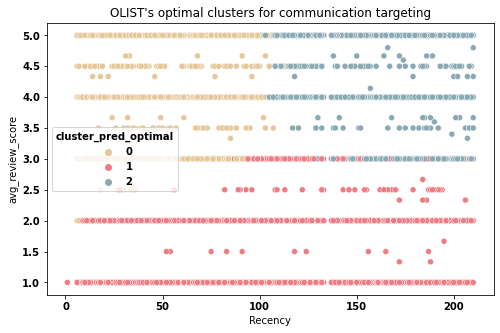

In [ ]:
colors = ["#E6C799", "#ED7C83", "#89AAB5"]
plt.figure()
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}
plt.rc('font', **font)
plt.figure(figsize=(8,5))  
plt.title("OLIST's optimal clusters for communication targeting")

sns.scatterplot(data=segmentation,x="Recency", y="avg_review_score",hue="cluster_pred_optimal", palette = sns.color_palette(colors) )
